# LAB - CUDA VISION WS 21/22


Done by - 
- Aysha Athar Siddiqui (3435155)
- Sugan Kanagasenthinathan (3315859)
- Vardeep Singh Sandhu (3344662)

## Table of Contents
-  [Import Modules](#import)
-  [Datasets](#datasets)
    -  [General structure of dataset folder in the code](#general)
    -  [Moving-MNIST Dataset](#mmnistdata)
    -  [KTH Action dataset](#kthdata)
-  [Dataloaders](#dataloaders)
    - [Moving-MNIST dataloader](#mmnistloader)
    -  [KTH Action dataloader](#kthloader)
-  [Importing models from checkpoints and experiment results](#model)
    -  [Moving-MNIST imports and some visualizations](#mmnistmodel)
    -  [KTH Action imports and some visualizations](#kthmodel)
- [Best Performing models](#best)
    -  [Moving-MNIST - trained with combined perceptual loss and onplateauLR schedular](#bestmmnist)
    -  [KTH Action - trained with combined perceptual loss and onplateauLR schedular](#bestkth)
-  [References]

<h3 id=import> Importing Modules </h3>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from model import Model
import utils
import wandb
import argparse
from attrdict import AttrDict
import matplotlib.pyplot as plt
import os

In [2]:
print("Module versions:")
print('\n'.join(f'{"> " + m.__name__}: {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
plt.style.use('seaborn')

Module versions:
> torch: 1.10.0
> wandb: 0.12.11
> argparse: 1.1


<h3 id="datasets">Datasets</h3>

<p id="general">The general structure of our data folder is described below. the sequences.txt has been modified and put up on Github in the folder datasets. It contained a video file that was corrupted, namely  person01_boxing_d4_uncomp.avi. We remove this from the original sequences.txt for simplicity. Everything else remains the same.<br>
    Initially, for the first time, change download flag to True in the <em>load_dataset()</em> function in utils.py for the KTH dataset. Once the .pt files have been generated, for the next time, change the download flag to False.<br></p>

<span style='font-family:courier'><p1><left>
&emsp;|── Cuda Lab Project <br>
   &emsp;&emsp; |── scripts ,..... <br>
   &emsp;&emsp; |── data <br>
           &emsp;&emsp;&emsp; |── KTH <br>
            &emsp;&emsp;&emsp;   &emsp;|── boxing <br>
            &emsp;&emsp;&emsp;    &emsp;|── handclapping<br>
            &emsp;&emsp;&emsp;   &emsp;|── handwaving<br>
            &emsp;&emsp;&emsp;    &emsp;|── jogging<br>
            &emsp;&emsp;&emsp;   &emsp;|── running<br>
            &emsp;&emsp;&emsp;   &emsp;|── walking<br>
            &emsp;&emsp;&emsp;   &emsp;|── sequences.txt<br>
            &emsp;&emsp;&emsp;   &emsp;|── data <br>
            &emsp;&emsp;&emsp;   &emsp;&emsp;|──All .pt files, processed video files<br>
            &emsp;&emsp;&emsp;|──MNIST<br>
                &emsp;&emsp;&emsp;&emsp;|── raw <br>
                &emsp;&emsp;&emsp;&emsp;|── processed<br>
                &emsp;&emsp;&emsp;&emsp;&emsp;|── moving_test.pt<br>
                &emsp;&emsp;&emsp;&emsp;&emsp;|── moving_train.pt
    </left>
    </p1>
    </span>

 
   

Path to the dataset folder which contains two seperate folders for MovingMNIST and KTH datasets

In [3]:
dataset_path="data"

To download KTH action dataset, download the dataset from the website https://www.csc.kth.se/cvap/actions/ or run the script download_kth.sh inside the data folder.

In [4]:
mnist_path = os.path.join(dataset_path, "MNIST")
kth_path = os.path.join(dataset_path, "KTH")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h5 id="mmnistdata">Loading and visualising a part of the training data for Moving-MNIST dataset.</h5>

---> Total  length of training set for Moving-MNIST dataset 60000
---> Total length of testing set for Moving-MNIST dataset 10000


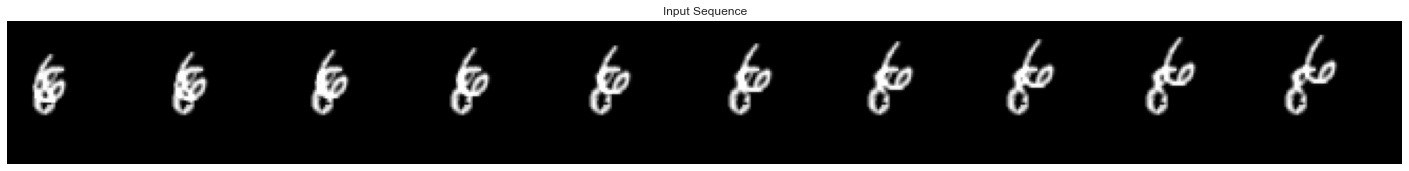

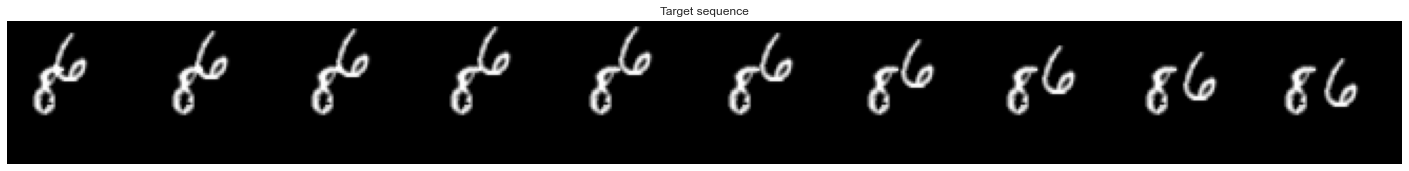

In [6]:
train_set_mnist, test_set_mnist = utils.load_information(mnist_path,dataset='smmnist')
print("---> Total  length of training set for Moving-MNIST dataset", len(train_set_mnist))
print("---> Total length of testing set for Moving-MNIST dataset", len(test_set_mnist))
utils.visualise_sample(train_set_mnist,False,device,False)

<h5 id="kthdata">Loading and visualising a part of the training data for KTH action dataset.</h5>

---> Total  length of training set for KTH dataset 23619
---> Total length of testing set for KTH dataset 12599


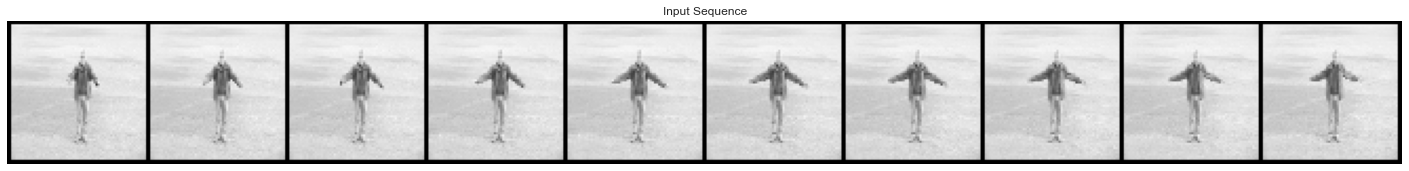

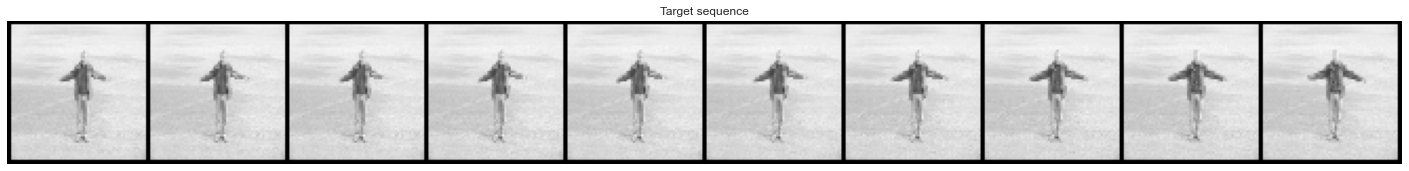

In [7]:
train_set_kth, test_set_kth = utils.load_information(kth_path,dataset='kth')
print("---> Total  length of training set for KTH dataset", len(train_set_kth))
print("---> Total length of testing set for KTH dataset", len(test_set_kth))
utils.visualise_sample(train_set_kth,False,device,False)

<h3 id="dataloaders"> Dataloaders </h3>

<h5 id="mmnistloader">Creating dataloaders for Moving-MNIST dataset with a batch size of 32.</h5>

In [8]:
train_loader_mmnist = DataLoader(
                dataset=train_set_mnist,
                batch_size=32,
                shuffle=True)
print("---> Length of train dataloader",len(train_loader_mmnist))

test_loader_mmnist = DataLoader(
                dataset=test_set_mnist,
                batch_size=32,
                shuffle=True)

print("---> Length of test dataloader",len(test_loader_mmnist))
print("Data loader for Moving-MNIST dataset ready !")

---> Length of train dataloader 1875
---> Length of test dataloader 313
Data loader for Moving-MNIST dataset ready !


<h5 id="kthloader">Creating dataloaders for KTH action dataset with a batch size of 32.</h5>

In [9]:
train_loader_kth = DataLoader(
                dataset=train_set_kth,
                batch_size=32,
                shuffle=True)
print("---> Length of train dataloader",len(train_loader_kth))

test_loader_kth = DataLoader(
                dataset=test_set_kth,
                batch_size=32,
                shuffle=True)

print("---> Length of test dataloader",len(test_loader_kth))
print("Data loader for KTH action dataset ready !")

---> Length of train dataloader 739
---> Length of test dataloader 394
Data loader for KTH action dataset ready !


<h3 id="model">Importing the models.</h3>

<h5 id="mmnistmodel">Moving-MNIST experiment models. </h5>

Below is the model trained on MSE loss and Onplateau Schedular without using Learning rate warmup. 

In [44]:
model = Model()
print("Model Loaded")

model_mse_onplateau_mmnist, _, epoch = utils.loading_model(model, "C:\\Users\\aysha\\Downloads\\MNIST 50 no ssim.pth")
model_mse_onplateau_mmnist= model_mse_onplateau_mmnist.to(device)

Model Loaded


Visualising results on the test dataset. The first line depicts the target sequence and the second depicts the frames our model predicted.

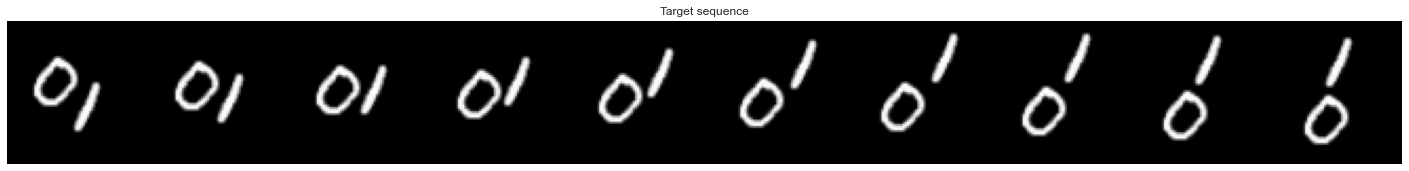

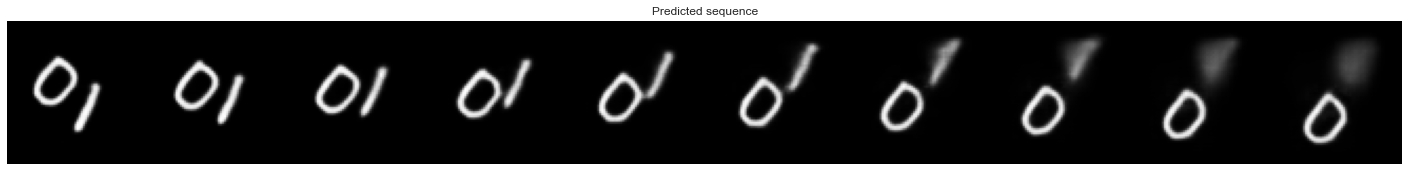

In [48]:
utils.visualise_sample(test_loader_mmnist, model_mse_onplateau_mmnist, device, True)

Another experiment was conducted by using combined loss with MAE and SSIM (Worst performing model) along with Exponential learning rate and learning rate warmup. Below are the results obtained by it.

In [33]:
model = Model()
print("Model Loaded")

model_mae_ssim_explr_mmnist, _, epoch = utils.loading_model(model, "C:\\Users\\aysha\\Downloads\\model_50_mae+ssim+mnist+explr+warmup.pth")
model_mae_ssim_explr_mmnist= model_mae_ssim_explr_mmnist.to(device)

Model Loaded


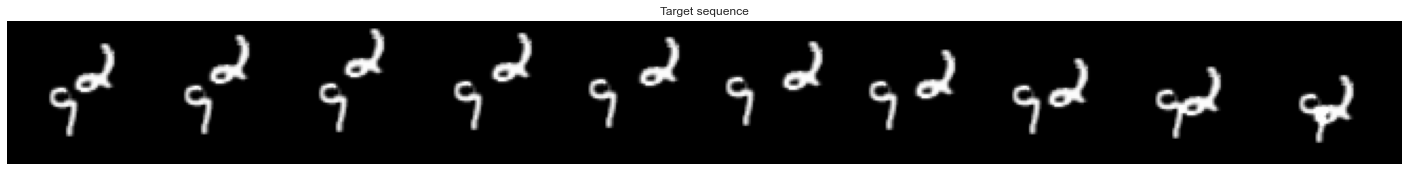

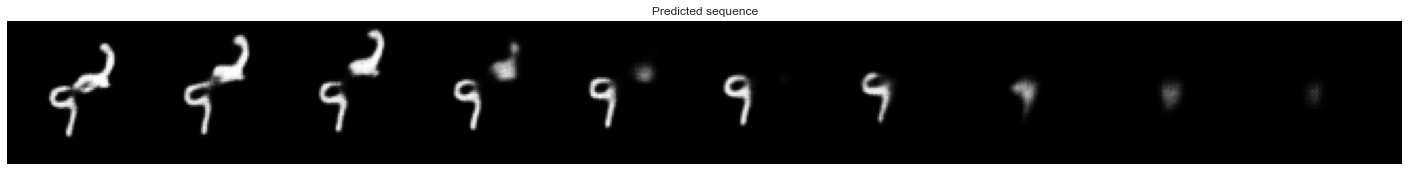

In [43]:
utils.visualise_sample(test_loader_mmnist, model_mae_ssim_explr_mmnist, device, True)

<h5 id="kthmodel"> KTH Action Experiment models</h5>

Below is a model trained on the KTH Action dataset using MSE as a loss criterion along with OnPlateau Schedular without learning rate warmup.

In [31]:
model = Model()
print("Model Loaded")

model_mse_onplateau_kth, _, epoch = utils.loading_model(model, "C:\\Users\\aysha\\Downloads\\model_50_KTH+mse+without ssim+without lrwarmup+plateau.pth")
model_mse_onplateau_kth= model_mse_onplateau_kth.to(device)

Model Loaded


Visualising results on the test dataset. The first line depicts the target sequence and the second depicts the frames our model predicted.

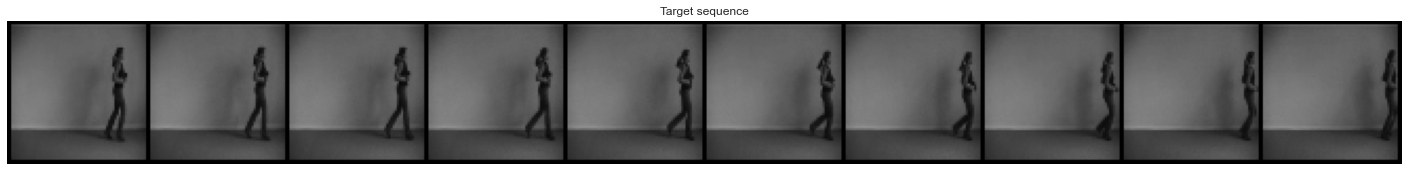

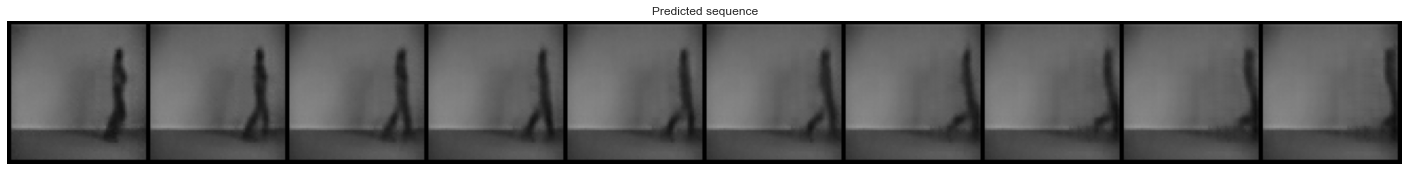

In [32]:
utils.visualise_sample(test_loader_kth, model_mse_onplateau_kth, device, True)

Another experiment involved using MSE and SSIM as loss citerion with ExponentialLR schedular and learning rate warmup. Below are the target and predicted frames by it.

In [29]:
model = Model()
print("Model Loaded")

model_mse_ssim_explr_kth, _, epoch = utils.loading_model(model, "C:\\Users\\aysha\\Downloads\\model_50_KTH+mse+without ssim+without lrwarmup+plateau.pth")
model_mse_ssim_explr_kth= model_mse_ssim_explr_kth.to(device)

Model Loaded


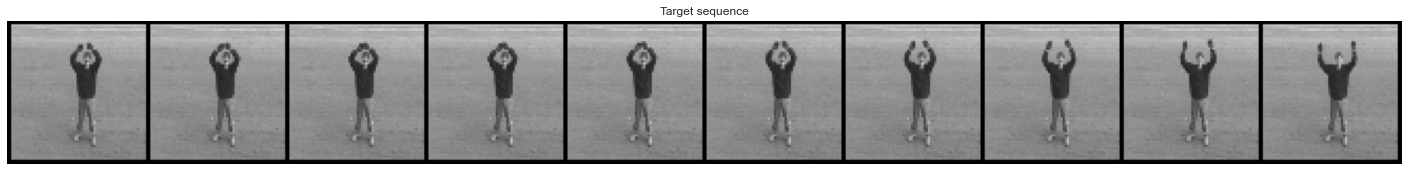

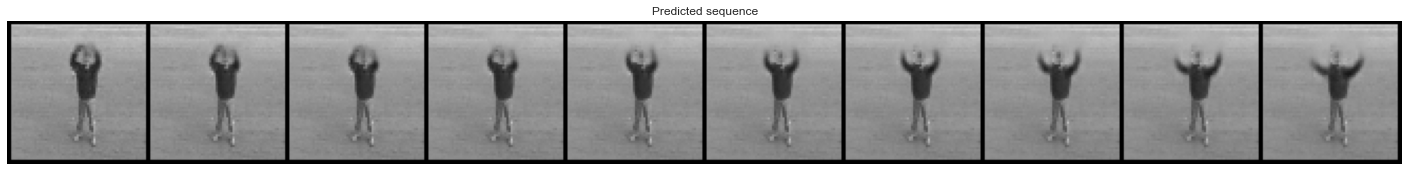

In [30]:
utils.visualise_sample(test_loader_kth, model_mse_ssim_explr_kth, device, True)

<h3 id="best">Best Performing models</h3>

<h5 id="bestmmnist"> Best performing model for Moving-MNIST was found to be the one trained on combined perceptual loss (MSE + $\lambda$ * SSIM). More details are given in the report. Below are the results from it from a test sample.

In [49]:
model = Model()
print("Model Loaded")

model_mse_ssim_onplateau_mmnist, _, epoch = utils.loading_model(model, "C:\\Users\\aysha\\Downloads\\model_50_ssim_lr_warmup_mnist.pth")
model_mse_ssim_onplateau_mmnist= model_mse_ssim_onplateau_mmnist.to(device)



Model Loaded


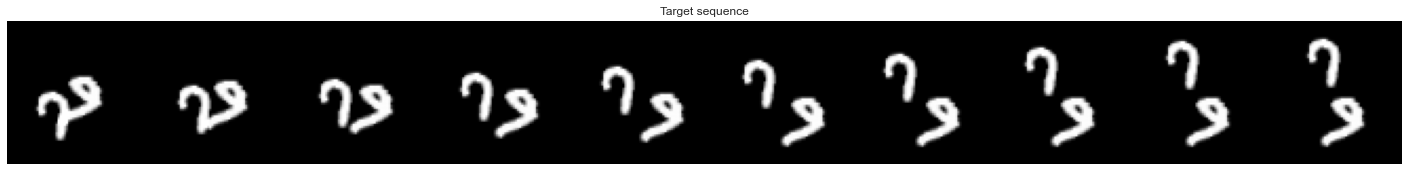

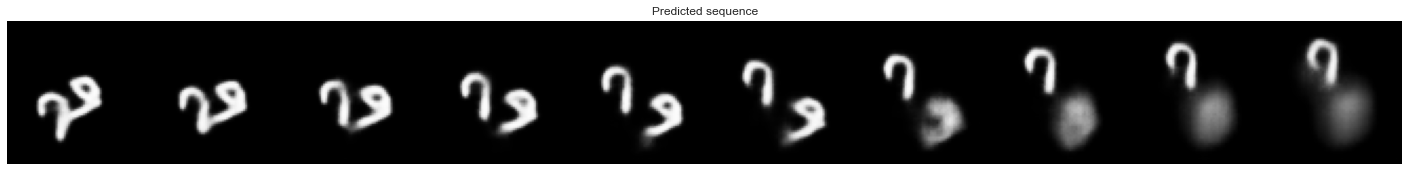

In [66]:
utils.visualise_sample(test_loader_mmnist, model_mse_ssim_onplateau_mmnist, device, True)

<h5 id="bestkth"> Best performing model for KTH action dataset was found to be the one trained on combined perceptual loss (MSE + $\lambda$ * SSIM). More details are given in the report. Below are the results from it from a test sample.

<h3 id=references> References </h3>

- <a ref="https://github.com/vkhoi/KTH-Action-Recognition">https://github.com/vkhoi/KTH-Action-Recognition</a></li>
- <a ref="https://github.com/edenton/svg">https://github.com/edenton/svg</a></li>
- <a ref="https://github.com/CeeBeeTree/KTH-Action-Recognition">https://github.com/CeeBeeTree/KTH-Action-Recognition</a></li>
- <a ref="https://github.com/pytorch/vision/blob/7947fc8fb38b1d3a2aca03f22a2e6a3caa63f2a0/torchvision/models/resnet.py#L37">https://github.com/pytorch/vision/blob/7947fc8fb38b1d3a2aca03f22a2e6a3caa63f2a0/torchvision/models/resnet.py#L37</a>
- <a ref="https://holmdk.github.io/2020/04/02/video_prediction.html">https://holmdk.github.io/2020/04/02/video_prediction.html</a>